## LLaVA Model
#### Model details
**Model type**: LLaVA is an open-source chatbot trained by fine-tuning LLaMA/Vicuna on GPT-generated multimodal instruction-following data. It is an auto-regressive language model, based on the transformer architecture.

Model date: LLaVA-v1.5-7B was trained in September 2023.

Paper or resources for more information: https://llava-vl.github.io/

#### License
Llama 2 is licensed under the LLAMA 2 Community License, Copyright (c) Meta Platforms, Inc. All Rights Reserved.

#### Intended use
Primary intended uses: The primary use of LLaVA is research on large multimodal models and chatbots.

Primary intended users: The primary intended users of the model are researchers and hobbyists in computer vision, natural language processing, machine learning, and artificial intelligence.

#### Training dataset
558K filtered image-text pairs from LAION/CC/SBU, captioned by BLIP.
158K GPT-generated multimodal instruction-following data.
450K academic-task-oriented VQA data mixture.
40K ShareGPT data.

In [1]:
# Standard library imports
import os
import re
from io import BytesIO
from typing import Optional

# Third-party library imports
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import requests
from tqdm import tqdm
from PIL import Image
from dataclasses import dataclass

torch.cuda.is_available()

True

In [22]:
!nvidia-smi

Mon Jun 24 21:12:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060 ...  WDDM  |   00000000:2B:00.0  On |                  N/A |
| 25%   39C    P8             27W /  175W |    6264MiB /   8192MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
!python -m bitsandbytes

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++ BUG REPORT INFORMATION ++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++ OTHER +++++++++++++++++++++++++++
CUDA specs: CUDASpecs(highest_compute_capability=(7, 5), cuda_version_string='118', cuda_version_tuple=(11, 8))
PyTorch settings found: CUDA_VERSION=118, Highest Compute Capability: (7, 5).
To manually override the PyTorch CUDA version please see: https://github.com/TimDettmers/bitsandbytes/blob/main/docs/source/nonpytorchcuda.mdx
CUDA SETUP: WARNING! CUDA runtime files not found in any environmental path.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++ DEBUG INFO END ++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Checking that the library is importable and CUDA is callable...
SUCCESS!
Installation was successful!


The directory listed in your path is found to be non-existent: \Users\user
The directory listed in your path is found to be non-existent: D:\Apps\Java
The directory listed in your path is found to be non-existent: \DESKTOP-M54TNDR
The directory listed in your path is found to be non-existent: %INTEL_DEV_REDIST%compiler\lib\mic
The directory listed in your path is found to be non-existent: C:\Users\user\OneDrive
The directory listed in your path is found to be non-existent: C:\Users\user\Documents\WindowsPowerShell\Modules
The directory listed in your path is found to be non-existent: C:\Program Files\JetBrains\WebStorm 2021.2.3\bin


In [2]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path

model_path = "models/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path),
    #load_8bit=True
)

d:\Apps\miniconda\envs\llava\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#######################
#######################
#######################
###########LLAVA############
{'device_map': 'auto', 'torch_dtype': torch.float16}
VISION CLIP CONFIGURE
clip: openai/clip-vit-large-patch14-336


d:\Apps\miniconda\envs\llava\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [01:26<00:00, 43.29s/it]


**Model architecture**

#### Core Components of LLaVa Model
#### LLama

**Component**: Embedding Layer and Decoder Layers

**Purpose**: Processes and transforms text inputs for language modeling tasks.

**Input**: Text tokens from a vocabulary of 32,000 items.

**Output**: 4,096-dimensional embeddings, progressively refined through 32 decoder layers.
#### CLIP Vision Tower
**Component**: Vision Transformer

**Purpose**: Converts visual inputs (images) into embeddings that can be integrated with text embeddings.

**Input**: Images, processed into patches and embedded.

**Output**: 1,024-dimensional image embeddings, further projected to 4,096 dimensions by the mm_projector.

#### mm_projector
**Component**: Multimodal Projector

**Purpose**: Projects visual embeddings into the same dimensional space as text embeddings to enable joint processing.

**Input**: 1,024-dimensional image embeddings.


In [3]:
model.config

LlavaConfig {
  "_name_or_path": "models/llava-v1.5-7b",
  "architectures": [
    "LlavaLlamaForCausalLM"
  ],
  "bos_token_id": 1,
  "eos_token_id": 2,
  "freeze_mm_mlp_adapter": false,
  "freeze_mm_vision_resampler": false,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "image_aspect_ratio": "pad",
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_length": 4096,
  "max_position_embeddings": 4096,
  "mm_hidden_size": 1024,
  "mm_projector_type": "mlp2x_gelu",
  "mm_resampler_type": null,
  "mm_use_im_patch_token": false,
  "mm_use_im_start_end": false,
  "mm_vision_select_feature": "patch",
  "mm_vision_select_layer": -2,
  "mm_vision_tower": "openai/clip-vit-large-patch14-336",
  "model_type": "llava",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": fals

In [4]:
model.get_vision_tower().config

CLIPVisionConfig {
  "_name_or_path": "openai/clip-vit-large-patch14-336",
  "attention_dropout": 0.0,
  "dropout": 0.0,
  "hidden_act": "quick_gelu",
  "hidden_size": 1024,
  "image_size": 336,
  "initializer_factor": 1.0,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "model_type": "clip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 14,
  "projection_dim": 768,
  "transformers_version": "4.31.0"
}

In [5]:
print(model)

LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm(

In [7]:

def load_image(image_file: str) -> Image.Image:
    """
    Loads an image from a file or URL and returns it as a PIL Image object.
    
    Args:
        image_file (str): File path or URL of the image.

    Returns:
        Image.Image: Loaded image as a PIL Image object.
    """
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    
    return image

In [8]:
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria


def load_image(image_file: str) -> Image.Image:
    """
    Loads an image from a file or URL and returns it as a PIL Image object.
    
    Args:
        image_file (str): File path or URL of the image.

    Returns:
        Image.Image: Loaded image as a PIL Image object.
    """
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    
    return image



def extract_first_coordinates(answer):
    start_idx = answer.find('[')
    end_idx = answer.find(']')
    
    if start_idx != -1 and end_idx != -1 and start_idx < end_idx:
        coordinates_str = answer[start_idx + 1:end_idx]
        return [float(coord.strip()) for coord in coordinates_str.split(',')]
    return None



@dataclass
class RunLlavaConfig:
    model_path: str
    model_base: Optional[str] = None
    model_name: Optional[str] = None
    query: str = ""
    conv_mode: Optional[str] = None
    image_file: str = ""
    sep: str = ","
    temperature: float = 0.1
    top_p: Optional[float] = None
    num_beams: int = 1
    max_new_tokens: int = 512
    load_8bit: bool = True

def run_llava(config: RunLlavaConfig):
    """
    Runs the LLava model with the given parameters.

    Args:
        config (RunLlavaConfig): Configuration parameters for the model.

    Returns:
        dict: The result containing the text answer and coordinates.
    """
    # Model initialization
    disable_torch_init()

    model_name = config.model_name or get_model_name_from_path(config.model_path)


    qs = config.query
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    if 'llama-2' in model_name.lower():
        auto_conv_mode = "llava_llama_2"
    elif "v1" in model_name.lower():
        auto_conv_mode = "llava_v1"
    elif "mpt" in model_name.lower():
        auto_conv_mode = "mpt"
    else:
        auto_conv_mode = "llava_v0"

    if config.conv_mode is not None and auto_conv_mode != config.conv_mode:
        print(f'[WARNING] the auto inferred conversation mode is {auto_conv_mode}, while `--conv-mode` is {config.conv_mode}, using {config.conv_mode}')
    else:
        config.conv_mode = auto_conv_mode

    conv = conv_templates[config.conv_mode].copy()
    print(config.conv_mode)

    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    print(prompt)
    
    image = load_image(config.image_file)
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            temperature=config.temperature,
            max_new_tokens=config.max_new_tokens,
            use_cache=True,
            stopping_criteria=[stopping_criteria])

    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(f'[Warning] {n_diff_input_output} output_ids are not the same as the input_ids')
    text_answer = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
    text_answer = text_answer.strip()
    if text_answer.endswith(stop_str):
        text_answer = text_answer[:-len(stop_str)]
    text_answer = text_answer.strip()

    return {
        "text_answer": text_answer,
        "coordinates": extract_first_coordinates(text_answer)
    }


# LXMert Model

#### LXMERT Architecture Overview
LXMERT (Learning Cross-Modality Encoder Representations from Transformers) is a model designed to integrate visual and language data for tasks like visual question answering and visual reasoning.

#### Architecture Components
* Object Relationship Encoder:

Processes visual data by treating each image as a sequence of detected objects.
Uses self-attention layers to understand relationships between these objects.
* Language Encoder:

Processes textual data using a transformer-based architecture.
Converts sentences into sequences of word embeddings with positional information.
* Cross-Modality Encoder:

Integrates visual and textual data using a combination of self-attention and cross-attention layers.
Aligns and combines information from both modalities, enabling the model to understand the relationships between words and visual elements.
* Attention Mechanisms

**Self-Attention**: Captures relationships within the same modality (either language or vision).

**Cross-Attention**: Aligns and integrates features across different modalities (vision and language), allowing the model to combine visual and textual information effectively.

In [5]:
#os.chdir(f'./transformer_explainability')

In [9]:
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering
from lxmert.lxmert.src.lxmert_lrp import LxmertForQuestionAnswering as LxmertForQuestionAnsweringLRP
from lxmert.lxmert.src.ExplanationGenerator import GeneratorOurs, GeneratorBaselines, GeneratorOursAblationNoAggregation
from captum.attr import visualization


In [10]:
class ModelUsage:
    def __init__(self, use_lrp=False):
        self.vqa_answers = utils.get_data(VQA_URL)

        # load models and model components
        self.frcnn_cfg = utils.Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        self.frcnn_cfg.MODEL.DEVICE = "cuda"

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=self.frcnn_cfg)

        self.image_preprocess = Preprocess(self.frcnn_cfg)

        self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

        if use_lrp:
            self.lxmert_vqa = LxmertForQuestionAnsweringLRP.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")
        else:
            self.lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")

        self.lxmert_vqa.eval()
        self.model = self.lxmert_vqa

        # self.vqa_dataset = vqa_data.VQADataset(splits="valid")

    def forward(self, item):
        URL, question = item
        
        self.image_file_path = URL

        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(URL)
        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections= self.frcnn_cfg.max_detections,
            return_tensors="pt"
        )
        inputs = self.lxmert_tokenizer(
            question,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        self.question_tokens = self.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids.flatten())
        self.text_len = len(self.question_tokens)
        # Very important that the boxes are normalized
        normalized_boxes = output_dict.get("normalized_boxes")
        features = output_dict.get("roi_features")
        self.image_boxes_len = features.shape[1]
        self.bboxes = output_dict.get("boxes")
        self.output = self.lxmert_vqa(
            input_ids=inputs.input_ids.to("cuda"),
            attention_mask=inputs.attention_mask.to("cuda"),
            visual_feats=features.to("cuda"),
            visual_pos=normalized_boxes.to("cuda"),
            token_type_ids=inputs.token_type_ids.to("cuda"),
            return_dict=True,
            output_attentions=False,
        )
        return self.output

In [11]:
def save_image_vis(image_file_path:str, bbox_scores):
    bbox_scores = image_scores
    _, top_bboxes_indices = bbox_scores.topk(k=1, dim=-1)
    print(bbox_scores)
    img = cv2.imread(image_file_path)
    mask = torch.zeros(img.shape[0], img.shape[1])
    print(top_bboxes_indices)
    print('shape:',img.shape)
    for index in range(len(bbox_scores)):
        if index in top_bboxes_indices.tolist():
            [x, y, w, h] = model_lrp.bboxes[0][index]
            print([x, y, w, h])
            curr_score_tensor = mask[int(y):int(h), int(x):int(w)]
            new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
            mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img = img * mask.cpu().data.numpy()
    cv2.imwrite(
            'lxmert/lxmert/experiments/paper/new.jpg', img)

In [12]:
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

In [13]:
model_lrp = ModelUsage(use_lrp=True)
lrp = GeneratorOurs(model_lrp)
baselines = GeneratorBaselines(model_lrp)
vqa_answers = utils.get_data(VQA_URL)



loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at C:\Users\user/.cache\torch\transformers\57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


#### Model inference 
- LXMert

In [14]:
def run_lxmert(image: Image.Image, question: str) -> list:
    """
    Runs LXMERT model on an image and question, returning coordinates of top-scoring object.

    Args:
        image (Image.Image): PIL Image object to process.
        question (str): Question related to the image.

    Returns:
        list: Coordinates of the top-scoring object's bounding box.
    """   
    # Save the image to a local file
    local_image_path = 'lxmert/lxmert/experiments/paper/online_image.jpg'
    image.save(local_image_path, 'JPEG')

    # Assuming the functions lrp.generate_ours and model_lrp.bboxes are defined elsewhere
    R_t_t, R_t_i = lrp.generate_ours((local_image_path, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
    image_scores = R_t_i[0]
    text_scores = R_t_t[0]

    values, indices = image_scores.topk(k=1, dim=-1)
    coordinates = model_lrp.bboxes[0][indices.cpu()][0].tolist()


    return coordinates

In [15]:
def plot_bounding_box(image: Image.Image, coordinates: list[int]):
    """
    Plots the image with a bounding box around the specified coordinates.

    Args:
        image (Image.Image): PIL Image object to plot.
        coordinates (list[int]): List containing [xmin, ymin, xmax, ymax] of the bounding box.

    Returns:
        None
    """
    xmin, ymin, xmax, ymax = coordinates

    # Plot the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)

    # Create a Rectangle patch
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

    # Add the Rectangle patch to the Axes
    plt.gca().add_patch(rect)

    # Remove margins and offsets
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')  # Turn off axis labels
    plt.gca().set_aspect('equal', adjustable='box')

    # Set axis limits to match image dimensions
    img_width, img_height = image.size
    plt.xlim(0, img_width)
    plt.ylim(img_height, 0)  # Invert y-axis to match image coordinates

    # Display the plot
    plt.show()

In [16]:
URL = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimages.pexels.com%2Fphotos%2F142520%2Fpexels-photo-142520.jpeg%3Fcs%3Dsrgb%26dl%3Dpexels-mali-maeder-142520.jpg%26fm%3Djpg&f=1&nofb=1&ipt=6b69f798280050cff0d9db6f74c018a3366ac9a110d0780f48fed820eb24032f&ipo=images"
question =  'Determine a detailed, accurate bounding box coordinates (x1, y1, x2, y2) for the corn '
image = load_image(URL)

lxmert_coordinates =  run_lxmert(image,question )

d:\Apps\miniconda\envs\llava\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


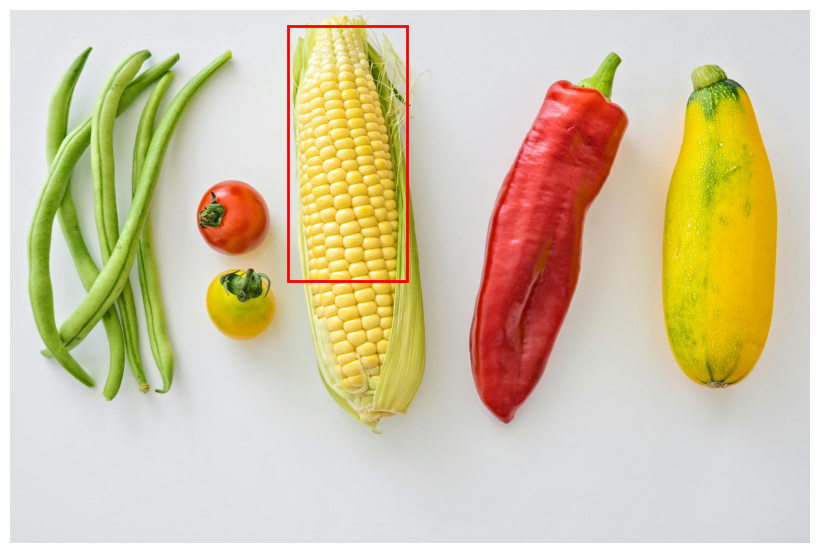

In [17]:
plot_bounding_box(image,lxmert_coordinates )

#### Model inference 
- LLaVa

In [18]:
prompt = "Determine a detailed, accurate bounding box coordinates (x1, y1, x2, y2) for the corn"
image_file = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimages.pexels.com%2Fphotos%2F142520%2Fpexels-photo-142520.jpeg%3Fcs%3Dsrgb%26dl%3Dpexels-mali-maeder-142520.jpg%26fm%3Djpg&f=1&nofb=1&ipt=6b69f798280050cff0d9db6f74c018a3366ac9a110d0780f48fed820eb24032f&ipo=images"
model_path = "models/llava-v1.5-7b"

In [19]:
from llava.mm_utils import get_model_name_from_path

args = RunLlavaConfig(**{
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 1,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512,
    "load_8bit":False,
})


In [20]:
output = run_llava(args)
output

llava_v1
You are an AI visual assistant, analyze a single image based on a sentence input and return the bounding box coordinates (x1, y1, x2, y2) of the main object. Coordinates should be in floating-point format between 0 and 1, representing top-left x, top-left y, bottom-right x, and bottom-right y USER: <image>
Determine a detailed, accurate bounding box coordinates (x1, y1, x2, y2) for the corn ASSISTANT:


{'text_answer': '[0.26, 0.08, 0.58, 0.93]',
 'coordinates': [0.26, 0.08, 0.58, 0.93]}

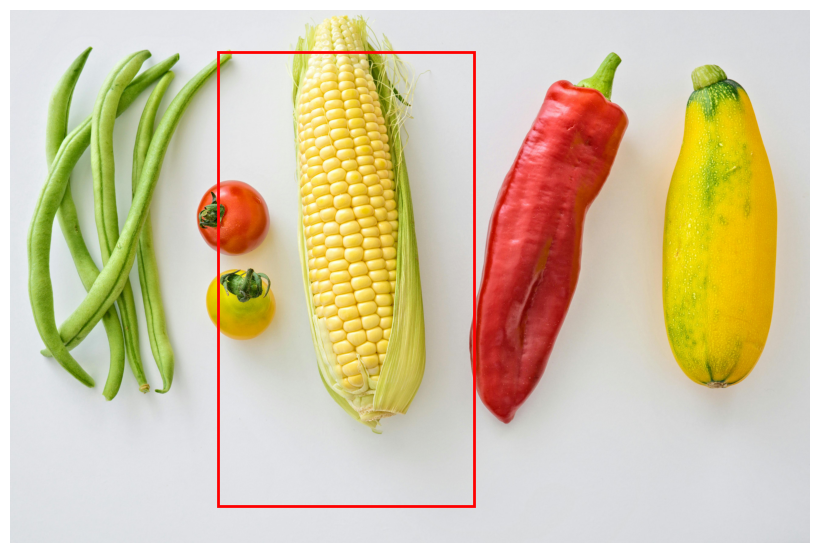

In [21]:
import matplotlib.pyplot as plt
from PIL import Image

normalized_coords = output['coordinates']

image = load_image(image_file)

# Convert normalized coordinates to pixel coordinates
img_width, img_height = image.size

xmin = normalized_coords[0] * img_width
ymin = normalized_coords[1] * img_height
xmax = normalized_coords[2] * img_width
ymax = normalized_coords[3] * img_height


plot_bounding_box(image,[xmin,ymin,xmax,ymax] )


In [ ]:
prompt = "Determine a detailed, accurate bounding box coordinates (x1, y1, x2, y2) for the old man"
image_file = "https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.hdwallpapers.in%2Fwalls%2Fpixars_up_movie_2009-normal.jpg&f=1&nofb=1&ipt=997ed255e2dbddef272d4881d5e5963375022febfc956f944d179a6d1b1f9a27&ipo=images"
model_path = "models/llava-v1.5-7b"

In [ ]:
prompt = "Determine a detailed, accurate bounding box coordinates (x1, y1, x2, y2) for the tiger"
image_file = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.nhm.ac.uk%2Fresources%2Fvisit%2Fwpy%2F2018%2Flarge%2F17.jpg&f=1&nofb=1&ipt=3d31b9bcd5fee156ffad008c80dbcd9bc6222eb5884d0844cc6dd9a0b344258e&ipo=images"
model_path = "models/llava-v1.5-7b"

In [ ]:
from llava.mm_utils import get_model_name_from_path
#from llava.eval.run_llava import eval_model

prompt = "Determine a detailed, accurate bounding box coordinates (x1, y1, x2, y2) for the animals"
image_file = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Finsidesources.com%2Fwp-content%2Fuploads%2F2018%2F12%2Fbigstock-Kids-Feed-Elephant-In-Zoo-Fam-241930129.jpg&f=1&nofb=1&ipt=39d5f2a2cd057fab309d0c5fe9106fd2da8fa213590d5014a4118619691709bc&ipo=images"
model_path = "models/llava-v1.5-7b"

## Experiment 1

In [44]:
from llava.mm_utils import get_model_name_from_path

prompt = "Determine a detailed, accurate bounding box coordinates (x1, y1, x2, y2) for the cob"
#image_file = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.nhm.ac.uk%2Fresources%2Fvisit%2Fwpy%2F2018%2Flarge%2F17.jpg&f=1&nofb=1&ipt=3d31b9bcd5fee156ffad008c80dbcd9bc6222eb5884d0844cc6dd9a0b344258e&ipo=images"
image_file = 'corn_rectangle.PNG'
model_path = "models/llava-v1.5-7b"


args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512,
    "load_8bit":True
})()


# Experiment 2

In [3]:
from llava.mm_utils import get_model_name_from_path
#from llava.eval.run_llava import eval_model

#prompt = "Return the bounding boxes coordinates (x1, y1, x2, y2) for all elephants in the image. Hint: use the illuminate areas to get the bounding boxes and ignore the black areas"
prompt = "Where is the screen?"
image_file = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fpixy.org%2Fsrc%2F533%2Fthumbs350%2F5337554.jpg&f=1&nofb=1&ipt=47db0eb3e38c71c78db90c18d5d1017b496ee6ed99e357b7b60692035ef253a7&ipo=images"
model_path = "models/llava-v1.5-7b"


args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512,
    "load_8bit":True
})()
